# **Prediction**

Using `Emulator.predict`, you can understand where and how your surrogate model is uncertain. Typically, emulators are more certain about predictions made in the parameter space of it's training datapoints, and pinpointing mean values for predicted inputs and their standard deviations can show you how good your emulator is able to make inferences about what's happening in your experimental data or simulation. 

This uncertainty quantification is very crucial in safety-critical applications, and can provide you a sense of trustworthiness when you're using these surrogate models to make informed decisions. 

Let's get predicting with `twinLab`!

In this Jupyter Notebook you will:

1. [Get started with an example dataset from the `twinLab` cloud.](#1-get-started-with-an-example-dataset)
2. [Use `Emulator.train` to create a surrogate model and train it on your dataset.](#2-train-your-emulator)
3. [Use your model to make predictions with `Emulator.predict`.](#3-predict-using-your-trained-emulator)
4. [Visualise your results and their uncertainty.](#4-viewing-the-results)
5. [Verify your results using `Emulator.sample`.](#5-sampling-from-your-emulator)


Start by importing all the necessary packages you need for this tutorial.

In [1]:
import numpy as np
import pandas as pd
import twinlab as tl


          ====== TwinLab Client Initialisation ======
          Version     : 2.13.0
          User        : jamie@digilab.co.uk
          Server      : https://tq327x8grc.execute-api.eu-west-2.amazonaws.com/dev
          Environment : /Users/jamiedonald-mccann/Desktop/twinLab/tutorials/.env



Make sure you set up your API key and other information to be able to use `twinLab`, either through a `.env` file, using `secrets`, or through `tl.set_user`/`tl.set_api_key`. 

### **1. Get started with an example dataset**

In this tutorial, you'll use the example dataset, "quickstart", which has a single input variable "x" and a single output, or response, variable "y". You might see "input" features also referred to as feature, predictor, or parameter in data science circles. 

In [2]:
# Download the example dataset
df = tl.load_example_dataset("quickstart")

# Check the dataframe before uploading
display(df)

,x,y
0,0.696469,-0.817374
1,0.286139,0.887656
2,0.226851,0.921553
3,0.551315,-0.326334
4,0.719469,-0.832518
5,0.423106,0.400669
6,0.980764,-0.164966
7,0.684830,-0.960764
8,0.480932,0.340115
9,0.392118,0.845795


`twinLab` contains a `Dataset` class with attributes and methods to process, view, and summarise the dataset. You must create `Dataset`s with an `id` which is used to access them. Using the `upload` method, you can then upload the `Dataset` to your `twinLab` cloud account.

In [3]:
# Initialise a Dataset object and give it a name
dataset = tl.Dataset("quickstart")

# Upload the dataset, passing in the dataframe
dataset.upload(df)

Double check your dataset has uploaded by checking whether it's included in the `tl.list_datasets` function.

In [4]:
# List all datasets on cloud
tl.list_datasets()

['quickstart']

### **2. Train your emulator**

You can use the `Emulator` class to train and implement surrogate models. Just like with datasets, you define these emulators with an  `id`, which is a unique ID under which your emulator will be saved as in the `twinLab` cloud.

In [5]:
# Initialise emulator
emulator_id = "example_emulator"

emulator = tl.Emulator(id=emulator_id)

When you want to train a model, you pass on your training requirements via arguments using a `TrainParams` object. `TrainParams` is a class that contains all the necessary parameters needed to train your model.

The `TrainParams` object has a lot of other parameters to customise your training including dimensionality reduction, type of estimator, automatic model selection and many others. Please refer to [twinLab-docs](https://twinlab.ai/python/reference/parameters.html#api-parameters) for more information.

In [6]:
# Define the training parameters for your emulator
params = tl.TrainParams(train_test_ratio=1.0)

Then, to train your model, you use the `Emulator.train` function, and input your `TrainParams` object as an argument to this function. 

In this example, we will just define the `train_test_ratio` parameter which specifies the amount of data that has to be allocated to emulator training from your entire dataset.

In [7]:
# Train the emulator using the train method
emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=params, verbose=True
)

Emulator 'example_emulator' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:05: Job status: processing
0:00:07: Job status: processing
0:00:10: Job status: processing
0:00:12: Job status: processing
0:00:16: Job status: processing
0:00:19: Job status: success
Training of emulator example_emulator is complete!


### **3. Predict using your trained emulator**

You've now trained and saved your emulator to the `twinLab` cloud account under your specified `emulator_id`. You can now use it to make predictions!

First define a dataset of inputs for which you want to find outputs; ensure that this is a `pandas.DataFrame` object. 

In [8]:
# Define the inputs for the dataset
x_eval = np.linspace(0, 1, 128)

# Convert to a dataframe
df_eval = pd.DataFrame({"x": x_eval})
display(df_eval)

,x
0,0.000000
1,0.007874
2,0.015748
3,0.023622
4,0.031496
...,...
123,0.968504
124,0.976378
125,0.984252
126,0.992126


Then call `Emulator.predict` with the keyword arguments being the dataset for which you want to evaluate. The aim with `Emulator.predict` is to see how closely your data aligns with your established emulator's training data. 


In [9]:
# Predict the results
predictions = emulator.predict(df_eval)

Job predict process ID: predict-nonchalant-quilled-particle
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: success
Mean predictions:
            y
0    0.618116
1    0.629521
2    0.641034
3    0.652643
4    0.664334
..        ...
123 -0.207133
124 -0.185094
125 -0.163708
126 -0.143000
127 -0.122988

[128 rows x 1 columns]
Standard deviation predictions:
            y
0    0.653885
1    0.638148
2    0.621944
3    0.605284
4    0.588181
..        ...
123  0.183473
124  0.182240
125  0.183786
126  0.188324
127  0.195862

[128 rows x 1 columns]


As you can see, there is a three-word string that gets returned with your job--"predict-word1-word2-word3". This is an identifier to make it easy to communicate between yourself and the `twinLab` team--if ever there's been a problem with your job you can report the job ID to us and we can track it down for you. You can also use it yourself with `tl.Emulator.get_process`, where you can retrieve the results of an inference method you've used. 

To track progress on larger,  more time-consuming jobs, be they with "predict" or other inference methods, you can use `list_processes`. You'll see that identifier from above keeping track of how long your predict job took!

In [11]:
emulator.list_processes_statuses(verbose=True)

Processes currently runnning:

No processes currently runnning

Successful processes:

{'process_id': 'predict-nonchalant-quilled-particle',
 'status': 'success',
 'start_time': '2024-08-29 14:39:38',
 'end_time': '2024-08-29 14:39:40'}

Processes that failed to complete:

No processes that failed to complete

Processes with unknown status:

No processes with unknown status



[{'process_id': 'predict-nonchalant-quilled-particle',
  'status': 'success',
  'start_time': '2024-08-29 14:39:38',
  'end_time': '2024-08-29 14:39:40'}]

The function returns a tuple of two `pandas.DataFrame` objects where the first dataframe gives the mean predictions of the emulator, and the second dataframe is the standard deviation for each of the predictions.

In [11]:
# Convert the result tuple to mean and standard deviation dataframes
result = pd.concat([predictions[0], predictions[1]], axis=1)
df_mean, df_stdev = result.iloc[:, 0], result.iloc[:, 1]
df_mean, df_stdev = df_mean.values, df_stdev.values
print(result.head())

          y         y
0  0.618116  0.653885
1  0.629521  0.638148
2  0.641034  0.621944
3  0.652643  0.605284
4  0.664334  0.588181


### **4. Viewing the results**

We can use the `Emulator.plot` functionality to plot the mean prediction and the uncertainty band of the emulator.

The `Emulator.plot` function internally uses the `Emulator.predict` function. There are a few arguments that can be passed to the `Emulator.predict` function, which can be done using the `tl.PredictParams` object. Refer to [twinLab Parameter Docs](https://twinlab.ai/python/reference/parameters.html#api-parameters) for more information on the parameter objects.

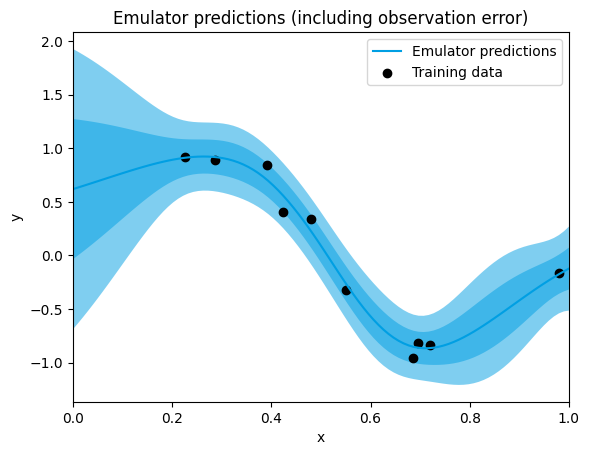

In [12]:
# Plot the predictions
plt = emulator.plot(x_axis="x", y_axis="y", label="Emulator predictions", x_lim=(0, 1))
# Plot the training data
plt.scatter(df["x"], df["y"], color="k", label="Training data")

plt.title("Emulator predictions (including observation error)")
plt.legend()
plt.show()

You can see that the uncertainty is low in the regions close to the datapoints, and high in the regions away from datapoints.

One of the `tl.PredictParams` parameters is called `observation_noise`. This parameter accounts for the noise in your observations while making predictions. This is by default set to `True`, and the plot above shows predictions that account for this noise in the observations.

You can see the uncertainty band to be much thicker even in the regions close to data points. If you set the `observation_noise` to `False`, we can plot the predictions again and test how this parameter affects your predictions.


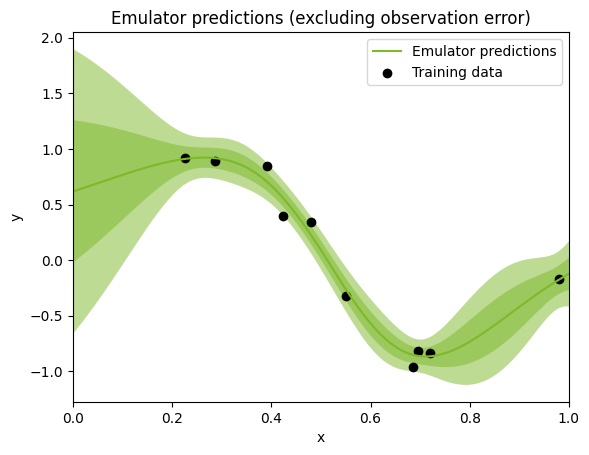

In [13]:
# Set the parameters for prediction
params = tl.PredictParams(observation_noise=False)

# Plot the emulator predictions
plt = emulator.plot(
    x_axis="x",
    y_axis="y",
    label="Emulator predictions",
    params=params,
    x_lim=(0, 1),
    color="#7DB928",
)
# Plot the training data
plt.scatter(df["x"], df["y"], color="k", label="Training data", zorder=1)

plt.title("Emulator predictions (excluding observation error)")
plt.legend()
plt.show()

You can see that the uncertainty band in the middle of the plot has become much thinner. This is because your emulator does not account for the noise in the observations when making predictions in this case.


### **5. Sampling from your emulator**

You can sample a number of functions from the trained emulator using `Emulator.sample()`. Like `Emulator.predict()`, you have a `SampleParams` object wherein you can choose different parameters to customise your sampling. 

First, you'll sample with default settings for `Emulator.sample()`. 

In [14]:
# Define the sample inputs
sample_inputs = pd.DataFrame({"x": np.linspace(0, 1, 128)})

# Define number of samples to calculate for each input
num_samples = 100

# Calculate the samples using twinLab
sample_result = emulator.sample(sample_inputs, num_samples)

# View the results in the form of a dataframe
display(sample_result)

Job sample process ID: sample-meowing-wry-lychee
0:00:00: Job status: processing
0:00:01: Job status: success
Samples:
            y                                                              \
            0         1         2         3         4         5         6   
0    0.334698  0.158569  0.859552  0.327923 -0.217702 -0.334370  0.338841   
1    0.369413  0.197524  0.883179  0.377797 -0.173709 -0.307473  0.363451   
2    0.401629  0.234163  0.907535  0.425365 -0.126347 -0.277179  0.393668   
3    0.431338  0.268386  0.933060  0.471434 -0.077282 -0.242704  0.427590   
4    0.459720  0.301732  0.960505  0.516495 -0.027265 -0.203692  0.463218   
..        ...       ...       ...       ...       ...       ...       ...   
123 -0.101119 -0.464059 -0.071800 -0.255215 -0.245549 -0.385110 -0.094811   
124 -0.087080 -0.402744 -0.054203 -0.220764 -0.227788 -0.374224 -0.044397   
125 -0.072833 -0.338105 -0.038409 -0.184858 -0.210125 -0.360245  0.007601   
126 -0.057726 -0.272541 -0.025103 

y                                                              \
            0         1         2         3         4         5         6   
0    0.334698  0.158569  0.859552  0.327923 -0.217702 -0.334370  0.338841   
1    0.369413  0.197524  0.883179  0.377797 -0.173709 -0.307473  0.363451   
2    0.401629  0.234163  0.907535  0.425365 -0.126347 -0.277179  0.393668   
3    0.431338  0.268386  0.933060  0.471434 -0.077282 -0.242704  0.427590   
4    0.459720  0.301732  0.960505  0.516495 -0.027265 -0.203692  0.463218   
..        ...       ...       ...       ...       ...       ...       ...   
123 -0.101119 -0.464059 -0.071800 -0.255215 -0.245549 -0.385110 -0.094811   
124 -0.087080 -0.402744 -0.054203 -0.220764 -0.227788 -0.374224 -0.044397   
125 -0.072833 -0.338105 -0.038409 -0.184858 -0.210125 -0.360245  0.007601   
126 -0.057726 -0.272541 -0.025103 -0.146282 -0.193325 -0.343965  0.060138   
127 -0.042471 -0.206222 -0.015132 -0.106239 -0.177082 -0.325014  0.114072   

                                   ...                                \
            7         8         9  ...        90        91        92   
0    1.057903  1.629926  0.215846  ...  0.556013  0.907363  1.382678   
1    1.063334  1.614785  0.239032  ...  0.538760  0.890371  1.394708   
2    1.066920  1.599474  0.260034  ...  0.523373  0.871490  1.408021   
3    1.068873  1.582908  0.279704  ...  0.510254  0.851214  1.420836   
4    1.070299  1.564868  0.299172  ...  0.501502  0.829755  1.430926   
..        ...       ...       ...  ...       ...       ...       ...   
123 -0.355017 -0.241929 -0.466843  ... -0.423688 -0.104619 -0.340998   
124 -0.319426 -0.198033 -0.450251  ... -0.417906 -0.032526 -0.311356   
125 -0.276933 -0.158119 -0.435047  ... -0.416297  0.042470 -0.275987   
126 -0.226108 -0.121322 -0.421142  ... -0.419081  0.120481 -0.234965   
127 -0.166763 -0.086824 -0.407926  ... -0.426138  0.201129 -0.189182   

                                                                           
           93        94        95        96        97        98        99  
0    2.212014  0.824443  1.972384  2.016561 -0.340395  0.962467  0.316456  
1    2.177546  0.833345  1.927063  2.021828 -0.267784  1.004367  0.326723  
2    2.138862  0.839725  1.876629  2.022297 -0.193965  1.042078  0.335911  
3    2.096482  0.843736  1.822415  2.016719 -0.118738  1.075063  0.346022  
4    2.051275  0.847461  1.766705  2.006050 -0.043763  1.103734  0.357628  
..        ...       ...       ...       ...       ...       ...       ...  
123 -0.167357  0.108419 -0.129181 -0.392895 -0.467369 -0.313588 -0.288167  
124 -0.123343  0.130804 -0.124426 -0.367035 -0.438006 -0.264414 -0.275125  
125 -0.080830  0.150476 -0.121341 -0.340474 -0.409519 -0.214107 -0.264278  
126 -0.039713  0.168745 -0.119634 -0.313571 -0.382300 -0.163833 -0.253587  
127  0.001007  0.185116 -0.118718 -0.287541 -0.357456 -0.113714 -0.241793  

[128 rows x 100 columns]

By plotting these sampling results over the top of the previous graph, you can get a nice visualisation of the sample data, with the model's uncertainty. 


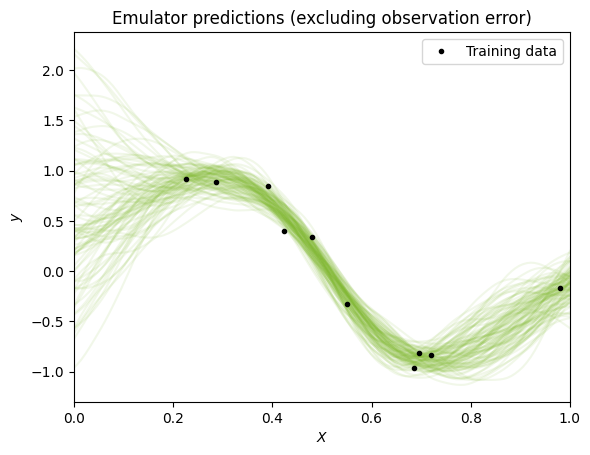

In [15]:
# Plot parameters
color_curve = "#7DB928"
alpha_curve = 0.10
color_data = "black"
plot_training_data = True
plot_model_bands = False

# Plotting training data
if plot_training_data:
    plt.plot(df["x"], df["y"], ".", color=color_data, label="Training data")
# Plot samples drawn from the model
plt.plot(
    sample_inputs, sample_result["y"], color=color_curve, alpha=alpha_curve, zorder=-1
)

plt.xlim((0.0, 1.0))
plt.xlabel(r"$X$")
plt.ylabel(r"$y$")
plt.title("Emulator predictions (excluding observation error)")
plt.legend()
plt.show()

Now you can experiment with the `SampleParams` object, and sample with the `observation_noise` set to true. You can use this to sample functions from the emulator in a way that accounts for inherent noise in the observations.

Note: There is an `observation_noise` parameter in `PredictParams` as well. This is used when making predictions with a trained emulator. The default value of `observation_noise` is true in this case. This means, when making predictions, we account for the noise in the observations by default. Therefore we can expect the default noise levels when making predictions, versus sampling, are different.

Job sample process ID: sample-bouncy-quixotic-angolatitan
0:00:00: Job status: processing
0:00:01: Job status: success
Samples:
            y                                                              \
            0         1         2         3         4         5         6   
0    0.561935  1.500472  1.082848  1.268192  1.993224  0.175122 -0.043959   
1    0.708890  1.725522  1.125011  1.048707  1.948155  0.361242 -0.026067   
2    0.779589  1.531963  0.950259  1.153065  2.218112  0.265622  0.333315   
3    0.724578  1.380013  1.123029  1.268810  1.858741  0.470503 -0.137080   
4    0.763629  1.301584  1.159776  1.293055  1.696831  0.218962  0.279369   
..        ...       ...       ...       ...       ...       ...       ...   
123 -0.383299 -0.413071 -0.350176 -0.035444 -0.099685  0.044090 -0.308804   
124 -0.299494 -0.368207 -0.221364 -0.098973 -0.162721 -0.046743 -0.340553   
125 -0.406111 -0.370546 -0.330979  0.051370 -0.511670 -0.188704 -0.253974   
126 -0.127223 -0.176932 -

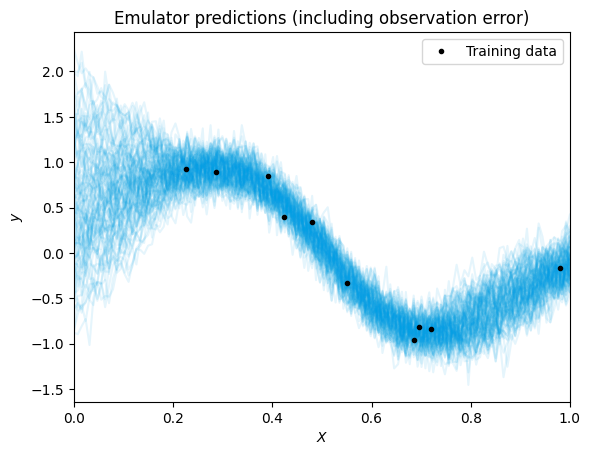

In [16]:
color_curve = "#009FE3"

# Set observation_noise to True
sample_params = tl.SampleParams(observation_noise=True)

# Sample from the emulator
sample_result_1 = emulator.sample(sample_inputs, num_samples, params=sample_params)

# Plot the training data
if plot_training_data:
    plt.plot(df["x"], df["y"], ".", color=color_data, label="Training data")
# Plot samples drawn from the model
plt.plot(
    sample_inputs, sample_result_1["y"], color=color_curve, alpha=alpha_curve, zorder=-1
)

plt.xlim((0.0, 1.0))
plt.xlabel(r"$X$")
plt.ylabel(r"$y$")
plt.title("Emulator predictions (including observation error)")
plt.legend()
plt.show()

If the `observation_noise` parameter is set to `True`, the individual samples are noisy. This can be attributed to the independent noise present in every data point. The samples are much smoother if you don't account for the noise in the observation; i.e when `observation_noise = False`.

### **Deleting datasets and campaigns**

You can delete your datasets and emulators to keep your `twinLab` cloud account storage tidy. 

Please be aware that this is permanent. Always consider keeping your data locally backed up. 

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.

In [17]:
# Delete dataset
dataset.delete()

# Delete emulator
emulator.delete()